In [1]:
import matplotlib.pyplot as plt

In [2]:
project_root = '/home/akarshkumar0101/nba-3d'

In [3]:
class Node():
    def __init__(self, name):
        self.name = name
        self.doc = ""
        self.references = []
        self.references_me = []
        self.children = []
# class Folder(Node):
#     def __init__(self, name):
#         super().__init__(name)
#         self.children = []
# class File(Node):
#     def __init__(self, name):
#         super().__init__(name)
#         self.functions = []
#         self.classes = []
# class Class(Node):
#     def __init__(self, name):
#         super().__init__(name)
#         self.functions =  []
# class Function(Node):
#     def __init__(self, name):
#         super().__init__(name)
# class Instance(Node):
#     def __init__(self, name):
#         super().__init__(name)

In [4]:
import os
import jedi
project = jedi.Project(project_root)

structure = {}
for root, dirs, files in os.walk(project_root):
    folder = '.'+root[len(project_root):]
    if '.git' in root or 'ball_tracking' in root:
        continue
    substruct = {}
    
    for file in files:
        if '.py' in file:
            script = jedi.Script(path=root+'/'+file, project=project)
            substruct[file] = script
    structure[folder] = substruct
    


In [5]:
root = Node('.')

In [6]:

def find_node_impl(root, ph):
    if len(ph)==0:
        return root
    for child in root.children:
        if child.name.name == ph[0].name:
            return find_node_impl(child, ph[1:])
    return None
    
def find_node(root, name):
    ph = get_parent_hierarchy(name)
    return find_node_impl(root, ph)

def get_parent_hierarchy(name):
    l = [name]
    while name.parent() is not None:
        l.append(name.parent())
        name = name.parent()
    l.reverse()
    return l

def register_node_impl(root, name):
    for child in root.children:
        if child.name.name == name.name:
            return child
        
    node = Node(name)
    root.children.append(node)
    return node
        
def register_node(root, name):
    ph = get_parent_hierarchy(name)
    for n in ph:
        root = register_node_impl(root, n)
    return root


In [7]:
for s, vs in structure.items():
    for file, script in vs.items():
        for name in script.get_names(definitions=True, references=False):
            if name.type=='module':
                pass
            if name.type=='function' or name.type=='class':
                node = register_node(root, name)
                node.doc = name.docstring()
                for ref in script.get_references(name.line, name.column):
                    refnode = register_node(root, ref)
                    node.references_me.append(refnode)


In [8]:
print(root.children[0].children[0].name)
print(root.children[0].children[0].references_me[1].name)
print(root.children[0].children[1].name)

<Name full_name='util.so3_log_map_impl', description='def so3_log_map_impl'>
<Name full_name='util.so3_log_map.so3_log_map_impl', description='so3_log_map_impl'>
<Name full_name='util.so3_log_map', description='def so3_log_map'>


In [9]:
print(root.children[5].children[3].doc)

draw_people(kp, ax=None, **kwargs)


In [10]:
def print_node(node):
    print('printing node: ', node.name)
    if type(node.name) is not str:
        print(node.name.type)
    print("Children:")
    for child in node.children:
        print_node(child)
        
    print()

# print_node(root)

In [27]:
import networkx as nx


G = nx.DiGraph()

def add_node_to_viz(G, root):
    if type(root.name) is str:
        G.add_node(root.name)
    else:
        G.add_node(root.name.name)
    for child in root.children:
        add_node_to_viz(G, child)
def add_edge_to_viz(G, root):
    for ref in root.references_me:
        G.add_edge(ref.name.parent().name, root.name.name)
    for child in root.children:
        add_edge_to_viz(G, child)
    
add_node_to_viz(G, root)
add_edge_to_viz(G, root)


# add_node_to_viz(G, root.children[0].children[0])
# add_node_to_viz(G, root.children[0].children[1])

# add_edge_to_viz(G, root.children[0].children[1])
# add_edge_to_viz(G, root.children[0].children[0])



# plt.figure(figsize=(20,20))
# nx.draw(G, with_labels=True, font_weight='bold')

In [43]:
import numpy as np

In [52]:
pos = {}

def eval_pos(root, pos, x=0, y=0):
    if type(root.name) is str:
        pos[root.name] = (x,y)
    else:
        pos[root.name.name] = (x,y)
    for i, child in enumerate(root.children):
        eval_pos(child, pos, x=x+i*np.e**(-2*y), y=y+1)
eval_pos(root, pos)

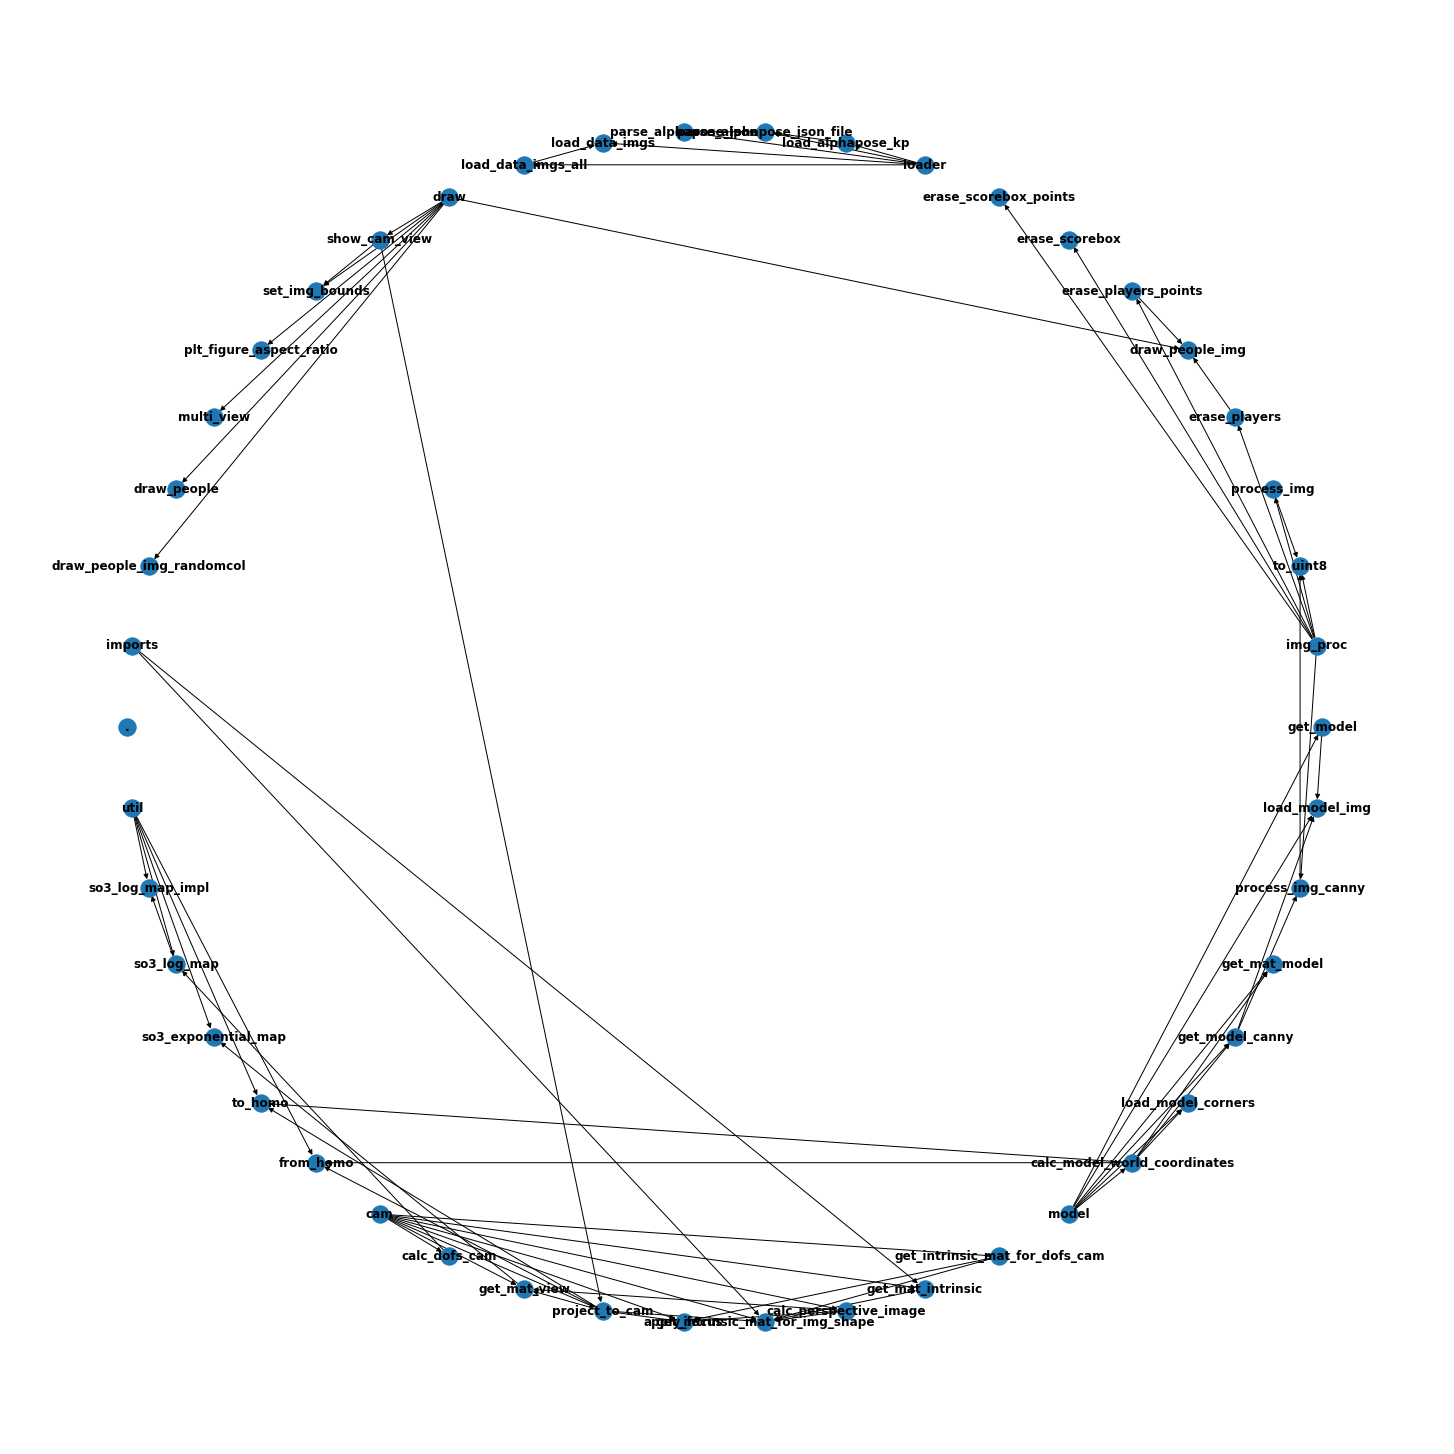

In [54]:

plt.figure(figsize=(20,20))
nx.draw(G, with_labels=True, font_weight='bold', pos=nx.shell_layout(G))


In [55]:
# pos = nx.nx_agraph.graphviz_layout(G)

In [91]:
d = {'nodes':[], 'links':[]}
i = 0
node_to_i = {}

def write_node(node, ):
    global i
    namesimple = node.name if type(node.name) is str else node.name.name
    d['nodes'].append({'name':namesimple, 'group':i ,'tooltip':node.doc})
    node_to_i[node] = i
    i+=1
    for child in node.children:
        write_node(child)
def write_edge(node):
    for ref in node.references_me:
        d['links'].append({'source': node_to_i[node], 'target': node_to_i[find_node(root,ref.name.parent())], 'value':1})
    
    for child in node.children:
        write_edge(child)
        
write_node(root)
write_edge(root)



In [93]:
import json


with open('data.json', 'w') as fp:
    json.dump(d, fp)

In [94]:
d

{'nodes': [{'name': '.', 'group': 0, 'tooltip': ''},
  {'name': 'util', 'group': 1, 'tooltip': ''},
  {'name': 'so3_log_map_impl',
   'group': 2,
   'tooltip': 'so3_log_map_impl(R, eps=1e-5)'},
  {'name': 'so3_log_map', 'group': 3, 'tooltip': 'so3_log_map(R, eps=1e-5)'},
  {'name': 'so3_log_map_impl', 'group': 4, 'tooltip': ''},
  {'name': 'so3_exponential_map',
   'group': 5,
   'tooltip': 'so3_exponential_map(axang, homogeneous=False)\n\nReturn the rotation matrix associated with counterclockwise rotation about\nthe given axis by theta radians.'},
  {'name': 'to_homo', 'group': 6, 'tooltip': 'to_homo(X, dim=-1)'},
  {'name': 'from_homo', 'group': 7, 'tooltip': 'from_homo(X, dim=-1)'},
  {'name': 'cam', 'group': 8, 'tooltip': ''},
  {'name': 'calc_dofs_cam',
   'group': 9,
   'tooltip': 'calc_dofs_cam(cam_position, cam_points_to, dofs_f)'},
  {'name': 'so3_log_map', 'group': 10, 'tooltip': ''},
  {'name': 'get_mat_view', 'group': 11, 'tooltip': 'get_mat_view(dofs_cam)'},
  {'name': 's